In [50]:
import os
import shutil

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.datasets import make_multilabel_classification
from transformers import pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import  CountVectorizer

#!pip install  wordcloud
import textwrap
from wordcloud import WordCloud

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, RegexpTokenizer

# Import pyLDAvis and pyLDAvis.gensim for LDA visualization
import pyLDAvis.gensim
# Import pickle for saving and loading Python objects
import pickle
# Import pyLDAvis for LDA visualization
import pyLDAvis
# Import os for file path operations

nltk.download('punkt');
nltk.download('wordnet');
nltk.download('stopwords');

# set print options
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

## some stuff for making pretty plots
from matplotlib import rcParams
from cycler import cycler

## Set plotting style and print options
sns.set_theme()
sns.set_style("whitegrid")
sns.set_context("paper") #Possible are paper, notebook, talk and poster
# Set figure format
wide_format, square_format = False, True
if wide_format:
    d = {'lines.linewidth': 2, 'axes.titlesize': 18, 'axes.labelsize': 18, 'xtick.labelsize': 12, 'ytick.labelsize': 12,\
     'legend.fontsize': 15, 'font.family': 'serif', 'figure.figsize': (9,6)}
if square_format:
    d = {'lines.linewidth': 2, 'axes.titlesize': 16, 'axes.labelsize': 14, 'xtick.labelsize': 10, 'ytick.labelsize': 10,\
     'legend.fontsize': 12, 'font.family': 'serif', 'figure.figsize': (6,6)}
    
d_colors = {'axes.prop_cycle': cycler(color = ['teal', 'navy', 'coral', 'plum', 'purple', 'olivedrab',\
         'black', 'red', 'cyan', 'yellow', 'khaki','lightblue'])}
rcParams.update(d)
rcParams.update(d_colors)

[nltk_data] Downloading package punkt to C:\Users\Simon
[nltk_data]     Andersen\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Simon
[nltk_data]     Andersen\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Simon
[nltk_data]     Andersen\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Preprocessing

#### Preprocessing is a huge chunk of the overall workload, as you may have noticed, and for text data, it involves some, but not usually all of the the following steps:

Document level preprocessing:
* Data cleaning (duplicate and noise removal)
* Data construction (deriving the features)
* Data reformatting and restructuring

Word level preprocessing:
* Word cleaning (Removal of illegal features and numbers, upper cases letters, mispellings etc)
* Removal of irrelevant words (stopwords)
* Tokenization
* n-gram construction
* Part-of-speech filtering
* Lemmatization
* Stemming
* Vectorization (embedding words as vectors in a large dimensional space)






In [6]:
# some useful functions 

def print_row(data, idx, target_column, symbols_per_line=100):
    value = str(data[target_column].iloc[idx])
    print(target_column)
    
    # Remove excess spaces
    value = ' '.join(value.split())
    
    # Wrap text while respecting word boundaries
    wrapped_value = textwrap.fill(value, width=symbols_per_line)
    
    print(wrapped_value)
    return

def print_list(list, elements_per_line=10):
    list_range = range(0, len(list), elements_per_line)

    for i in list_range:
        print(*list[i:i+elements_per_line])
    return

# Define a function to find unique words in a text
def find_unique_words(text, word_list):
    for word in text.split():
        if word not in word_list:
            word_list.append(word)
    return

In [7]:
data400 = pd.read_csv('type+2+diabetes_400.csv', index_col=0)
data500 = pd.read_csv('type+2+diabetes_500.csv', index_col=0)

# concatenate the two dataframes and drop duplicates
data = (pd.concat([data400, data500], axis=0)).drop_duplicates('ArticleTitle')
data.count()

Authors         491
ArticleTitle    506
Date            493
Abstract        203
Keywords         74
Affiliations    331
dtype: int64

In [8]:
# drop rows with missing values in the 'Authors' and 'Date' column
data.dropna(subset=['Authors', 'Date'], inplace=True)

# Extract year and month from the 'Date' column
data['Year'] = (data['Date'].apply(lambda x: str(x)[-4:])).astype(int)

# Map month values Jan. Feb. etc. to numbers
months = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6, 'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}

extract_months = lambda x: np.nan if not '.' in x else months[x.split('.')[0]]
data['Month'] = (data['Date'].astype(str).apply(extract_months)).astype(float)
data.head()

,Authors,ArticleTitle,Date,Abstract,Keywords,Affiliations,Year,Month
0,"N. Javeed and AV. Matveyenko,","""Circadian Etiology of Type 2 Diabetes Mellitu...",Mar. 2018,"""The epidemic of Type 2 diabetes mellitus nece...",NaN,"""Department of Physiology and Biomedical Engin...",2018,3.0
1,"Y. Wu, Y. Ding, Y. Tanaka and W. Zhang,","""Risk factors contributing to type 2 diabetes ...",2014,"""Type 2 diabetes is a serious and common chron...","genetic factor, intervention trial., lifestyle...","""1. Lab of Molecular Immunology, Zhejiang Prov...",2014,NaN
2,"B. Fletcher, M. Gulanick and C. Lamendola,","""Risk factors for type 2 diabetes mellitus."",",Jan. 2002,"""Genetic, environmental, and metabolic risk fa...",NaN,"""University of North Florida, Department of Nu...",2002,1.0
3,"J. Damanik and E. Yunir,","""Type 2 Diabetes Mellitus and Cognitive Impair...",Apr. 2021,"""Type 2 diabetes mellitus (T2DM) is strongly a...","cognitive impairment, type 2 diabetes mellitus,","""Department of Internal Medicine, Faculty of M...",2021,4.0
4,"S. Brunton,","""Pathophysiology of Type 2 Diabetes: The Evolu...",Apr. 2016,"""This review article explores scientists' curr...",NaN,"""Primary Care Metabolic Group Charlotte, NC, U...",2016,4.0


Since we would like to extract information from entire conversations (possibly differentiated whether it is the patient or doctor speaking), we group the data by conversation. To also group by speaker, use the outcommented line of code instead.

Simply grouping by conversation means that each conversation takes up 1 row, and that our 'document' is a conversation

In [9]:
# In the following, we will make topics based on the keywords column. You could instead choose to work with the abstract column.
column_to_tokenize = 'Abstract'
target_column = column_to_tokenize + '_tokenized'

# drop rows with missing values column to tokenize
data.dropna(subset=[column_to_tokenize], inplace=True)
# make a new columns for the tokenized target column
data[target_column] = data[column_to_tokenize].astype(str)


data[target_column].iloc[0].strip('"')
data[target_column] = data[target_column].map(lambda x: x.strip('"').strip())

In [10]:
# Remove common words such as me, our, you etc.
stop_words = nltk.corpus.stopwords.words('english')

# Add some more stopwords, i.e. words to be removed
new_stopwords = ['diabetes', 'type', 'mellitus']
stop_words.extend(new_stopwords)

from string import punctuation
print("List of words to be removed:\n")
print_list(stop_words, elements_per_line=10)

# Decapitalize text
data[target_column] = data[target_column].apply(lambda x: x.lower())
# Remove numbers
data[target_column] = data[target_column].apply(lambda x: ''.join([i for i in x if not i.isdigit()]))
# Remove punctuation
tokenizer = RegexpTokenizer(r'\w+')
data[target_column] = data[target_column].apply(lambda x: tokenizer.tokenize(x))
# remove stop words
data[target_column] = data[target_column].apply(lambda x: ' '.join([word for word in x if word not in (stop_words)]))

print("\nFirst row before preprocessing:")
print_row(data, target_column=column_to_tokenize, idx=0, symbols_per_line=100)   
print("\nFirst row after preprocessing:")
print_row(data, target_column=target_column, idx=0, symbols_per_line=100) 

List of words to be removed:

i me my myself we our ours ourselves you you're
you've you'll you'd your yours yourself yourselves he him his
himself she she's her hers herself it it's its itself
they them their theirs themselves what which who whom this
that that'll these those am is are was were be
been being have has had having do does did doing
a an the and but if or because as until
while of at by for with about against between into
through during before after above below to from up down
in out on off over under again further then once
here there when where why how all any both each
few more most other some such no nor not only
own same so than too very s t can will
just don don't should should've now d ll m o
re ve y ain aren aren't couldn couldn't didn didn't
doesn doesn't hadn hadn't hasn hasn't haven haven't isn isn't
ma mightn mightn't mustn mustn't needn needn't shan shan't shouldn
shouldn't wasn wasn't weren weren't won won't wouldn wouldn't diabetes
type mellitus

First row 

In [11]:
# Let's find the no. of words and no. of unique words in the target column

# Number of words in target column
Nwords = data[target_column].apply(lambda x: len(x.split()));
unique_words_before_lemmatization = []

for row in data[target_column]:
    find_unique_words(row, unique_words_before_lemmatization)

Nunique_words_before_lemmatization = len(unique_words_before_lemmatization);
# sort unique words
unique_words = sorted(unique_words_before_lemmatization);

print("Total Number of words in abstracts", Nwords.sum())
print("Number of unique words in abstracts: ", Nunique_words_before_lemmatization)
print("\nThe first 100 unique words: \n")
print_list(unique_words[:100], elements_per_line=10)

Total Number of words in abstracts 14833
Number of unique words in abstracts:  3375

The first 100 unique words: 

aberrations abilities ability abnomalies abnormal abnormalities absence absolute absorption abundance
abundant ac academic acanthosis acarbose accelerate accelerated acceptable acceptance accepted
access accompanied accompanies accompany accompanying accord according accordingly account accounting
accounts accumulating accumulation accurate ace achievable achieve achieved achievement achieving
acid acidosis acids acknowledge across acs act acting action actions
activate activated activates activation active activities activity acupoint acupuncture acute
ad adapt adaptation adaptations adapted added addition additional additionally additions
address addressed addresses addressing adequate adhere adherence adhesion adipocytes adipocytokines
adipogenesis adipokines adiponectin adipose adiposity adjunct adjusted adjusting adjustment administration
admission adolescence adolesc

We see that different forms of the same words are present like e.g. ability and abilities. This introduces unnecessary redundancy, and we fix it by lemmatization below, i.e. reducing different words forms to their unconjugated 'base', like e.g. letting balls --> ball and   tried --> try.

Another approach (which we won't use) is to reduce all words to their stem by using stemming (this approach will group different word classes together, letting e.g. analyze, analysis --> analy).

In [12]:
wordnet_lemmatizer = WordNetLemmatizer()

# Lemmatize target column. It can only lemmatize one word class at the time, so we need to specify the word classes
# (noun = n, verb = v, adjective = a, adverb = r, sattelite adjective = s) for each word in the text column
word_classes = ['n', 'v', 'a', 'r', 's']
for word_class in word_classes:
    data[target_column] = data[target_column].apply(lambda x: ' '.join([wordnet_lemmatizer.lemmatize(word, word_class) for word in x.split()]))

# Let's find the no. of unique words in target column after lemmatization
unique_words = []

for row in data[target_column]:
    find_unique_words(row, unique_words)
Nunique_words = len(unique_words);
# sort unique words
unique_words = sorted(unique_words);

print("Number of unique words in dataset after lemmatization: ", Nunique_words)
print("Through lemmatization, we have reduced the number of unique words by: ", Nunique_words_before_lemmatization - Nunique_words)
print("\nThe first 100 unique words after lemmatization: \n")
print_list(unique_words[:100], elements_per_line=10)


Number of unique words in dataset after lemmatization:  2685
Through lemmatization, we have reduced the number of unique words by:  690

The first 100 unique words after lemmatization: 

aberration ability abnomalies abnormal abnormality absence absolute absorption abundance abundant
ac academic acanthosis acarbose accelerate accept acceptable acceptance access accompany
accord accordingly account accumulate accumulation accurate ace achievable achieve achievement
acid acidosis acknowledge across act action activate activation active activity
acupoint acupuncture acute ad adapt adaptation add addition additional additionally
address adequate adhere adherence adhesion adipocytes adipocytokines adipogenesis adipokines adiponectin
adipose adiposity adjunct adjust adjustment administration admission adolescence adolescent adopt
adoption adult adulthood advance advancement adverse adversely advise advocate aerobic
aetiology affair affect afflict affliction affordable africa african age agen

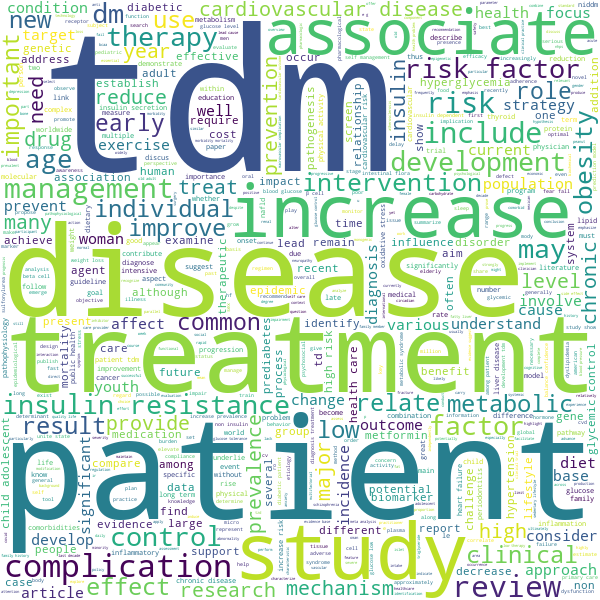

In [13]:
# Join the different processed titles together.
long_string = ','.join(list(data[target_column].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", height=600,width=600, max_words=5000, contour_width=6, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

#### At this point, we can go back and remove any additional words that we deem irrelevant.

************

### TF-IDF
Let us construct a dataframe holding the tfidf score for all words. The tfidf score is a measure of the importance of each word, in the sense that 1) a word occurring in more documents is deemed more important 2) a word ocurring more frequently overall is deemed less important. Condition 2) reduces the importance of very common words.

To do use, we use a vectorizer, which assigns a tuple (conv_id, token_id) to each token (word in this case), as well as a tfidf score.

In [14]:
# Convert the target column to a list of strings
to=data[target_column].tolist()
## Store the conversation indices in a list (for later use)
target_cols_idx = data.index.tolist()

# Initialize the vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Check if the list is empty
if len(to) == 0:
    print("The list is empty.")
else:
    # Create the tf-idf matrix
    tfidf_vector = tfidf_vectorizer.fit_transform(to)

# Let us print the first row of the tf-idf matrix
print("The TFIDF vector for the first row: \n", tfidf_vector[0])


The TFIDF vector for the first row: 
   (0, 459)	0.15926433450239164
  (0, 1495)	0.10738286487479873
  (0, 513)	0.21252379694775977
  (0, 1933)	0.11679344863717006
  (0, 2419)	0.12245642802965345
  (0, 2046)	0.22914438996864778
  (0, 1720)	0.20073129853048258
  (0, 2152)	0.08707893277782182
  (0, 101)	0.13085124306422644
  (0, 2503)	0.15484548714120056
  (0, 1773)	0.14937875786884197
  (0, 204)	0.15926433450239164
  (0, 2591)	0.12902910192315967
  (0, 2407)	0.26951628651520654
  (0, 397)	0.42504759389551955
  (0, 1394)	0.15926433450239164
  (0, 866)	0.11952722318738454
  (0, 712)	0.07088757327176336
  (0, 615)	0.20073129853048258
  (0, 889)	0.22914438996864778
  (0, 227)	0.21252379694775977
  (0, 2336)	0.1272845226332642
  (0, 1932)	0.22914438996864778
  (0, 2443)	0.25805820384631933
  (0, 1650)	0.17231820709231743
  (0, 667)	0.10634505181943807
  (0, 1609)	0.22914438996864778
  (0, 838)	0.13686072854464268


In [17]:
# Create a dataframe from the tf-idf matrix, with each column representation a word
tfidf_df = pd.DataFrame(tfidf_vector.toarray(), index=target_cols_idx, columns=tfidf_vectorizer.get_feature_names_out())

# Add a row with the document frequency for each word (number of documents in which the word appears)
tfidf_df.loc['Document_Frequency'] = (tfidf_df > 0).sum()

In [20]:
# Let's have a look
tfidf_df.tail(10)

aberration  ability  abnomalies  abnormal  abnormality  \
244                        0.0      0.0         0.0  0.000000          0.0   
382                        0.0      0.0         0.0  0.000000          0.0   
412                        0.0      0.0         0.0  0.327447          0.0   
434                        0.0      0.0         0.0  0.000000          0.0   
443                        0.0      0.0         0.0  0.000000          0.0   
444                        0.0      0.0         0.0  0.000000          0.0   
466                        0.0      0.0         0.0  0.000000          0.0   
471                        0.0      0.0         0.0  0.000000          0.0   
487                        0.0      0.0         0.0  0.000000          0.0   
Document_Frequency         2.0      4.0         1.0  4.000000          6.0   

                    absence  absolute  absorption  abundance  abundant   ac  \
244                     0.0       0.0         0.0        0.0       0.0  0.0   
382                     0.0       0.0         0.0        0.0       0.0  0.0   
412                     0.0       0.0         0.0        0.0       0.0  0.0   
434                     0.0       0.0         0.0        0.0       0.0  0.0   
443                     0.0       0.0         0.0        0.0       0.0  0.0   
444                     0.0       0.0         0.0        0.0       0.0  0.0   
466                     0.0       0.0         0.0        0.0       0.0  0.0   
471                     0.0       0.0         0.0        0.0       0.0  0.0   
487                     0.0       0.0         0.0        0.0       0.0  0.0   
Document_Frequency      1.0       1.0         1.0        2.0       2.0  4.0   

                    academic  acanthosis  acarbose  accelerate  accept  \
244                      0.0    0.000000   0.24506         0.0     0.0   
382                      0.0    0.000000   0.00000         0.0     0.0   
412                      0.0    0.000000   0.00000         0.0     0.0   
434                      0.0    0.000000   0.00000         0.0     0.0   
443                      0.0    0.147724   0.00000         0.0     0.0   
444                      0.0    0.000000   0.00000         0.0     0.0   
466                      0.0    0.000000   0.00000         0.0     0.0   
471                      0.0    0.000000   0.00000         0.0     0.0   
487                      0.0    0.000000   0.00000         0.0     0.0   
Document_Frequency       2.0    2.000000   1.00000         2.0     4.0   

                    acceptable  acceptance  access  accompany  accord  \
244                        0.0         0.0     0.0        0.0     0.0   
382                        0.0         0.0     0.0        0.0     0.0   
412                        0.0         0.0     0.0        0.0     0.0   
434                        0.0         0.0     0.0        0.0     0.0   
443                        0.0         0.0     0.0        0.0     0.0   
444                        0.0         0.0     0.0        0.0     0.0   
466                        0.0         0.0     0.0        0.0     0.0   
471                        0.0         0.0     0.0        0.0     0.0   
487                        0.0         0.0     0.0        0.0     0.0   
Document_Frequency         1.0         1.0     3.0        5.0     5.0   

                    accordingly   account  accumulate  accumulation  accurate  \
244                         0.0  0.000000         0.0           0.0       0.0   
382                         0.0  0.000000         0.0           0.0       0.0   
412                         0.0  0.000000         0.0           0.0       0.0   
434                         0.0  0.000000         0.0           0.0       0.0   
443                         0.0  0.116421         0.0           0.0       0.0   
444                         0.0  0.000000         0.0           0.0       0.0   
466                         0.0  0.000000         0.0           0.0       0.0   
471                     

In [24]:
# To find the tf-idf score for a specific word (and their document frequency), simply do
tfidf_slice = tfidf_df[['health', 'stress', 'sleep']]
# We see that only 'health' and 'stress' is present in the last 10 abstracts and occurs in 46 and 11 abstracts, respectively
tfidf_slice.tail(10)

,health,stress,sleep
244,0.000000,0.000000,0.0
382,0.000000,0.000000,0.0
412,0.000000,0.000000,0.0
434,0.000000,0.079887,0.0
443,0.069325,0.000000,0.0
444,0.000000,0.000000,0.0
466,0.000000,0.000000,0.0
471,0.000000,0.000000,0.0
487,0.000000,0.000000,0.0
Document_Frequency,46.000000,11.000000,3.0


From tfidf_df we'll construct another Pandas dataframe, where each row contains the target columns index, the word, and its
tfidf score. This enables us to analyze the word importances on a word level as opposed to a document level

In [27]:
# Drop the row with the document frequency
tfidf_by_word = tfidf_df.drop('Document_Frequency', errors='ignore')
# Reshape the dataframe
tfidf_by_word = tfidf_by_word.stack().reset_index().rename(columns={0:'tfidf', 'level_0': 'target_col_idx','level_1': 'term'})
tfidf_by_word.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 523516 entries, 0 to 523515
Data columns (total 3 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   target_col_idx  523516 non-null  int64  
 1   term            523516 non-null  object 
 2   tfidf           523516 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 12.0+ MB


In [34]:
# let's have a look at the words with non-zero tf-idf score for the first document
target_col_index = 0

# mask for the target column
index_mask = tfidf_by_word['target_col_idx'] == target_col_index
# only show words with a minimum tf-idf score
tfidf_min_mask = tfidf_by_word['tfidf'] > 0

tfidf_by_word[index_mask & tfidf_min_mask].sort_values(by=['tfidf'], ascending=[False])


,target_col_idx,term,tfidf
397,0,circadian,0.425048
2407,0,system,0.269516
2443,0,therapeutic,0.258058
1609,0,necessitate,0.229144
1932,0,preventative,0.229144
889,0,expansion,0.229144
2046,0,rationale,0.229144
227,0,attenuate,0.212524
513,0,consequent,0.212524
1720,0,outline,0.200731


In [35]:
#  Using the new dataframe, we can e.g. find thewords with the highest TF–IDF across all documents
tfidf_by_word.sort_values(by=['tfidf'], ascending=[False]).head(15)


,target_col_idx,term,tfidf
463265,366,illness,0.712162
442517,347,periodontitis,0.704038
432295,324,sleep,0.700761
286395,173,cv,0.694651
362773,251,screen,0.671612
407588,290,nafld,0.662702
90610,40,thyroid,0.656774
72097,30,woman,0.617567
189965,101,cancer,0.615192
485629,25,schizophrenia,0.613421


Let's visualize the top 10 words with the highest tf–idf score for the first 10 conversations using a heat map

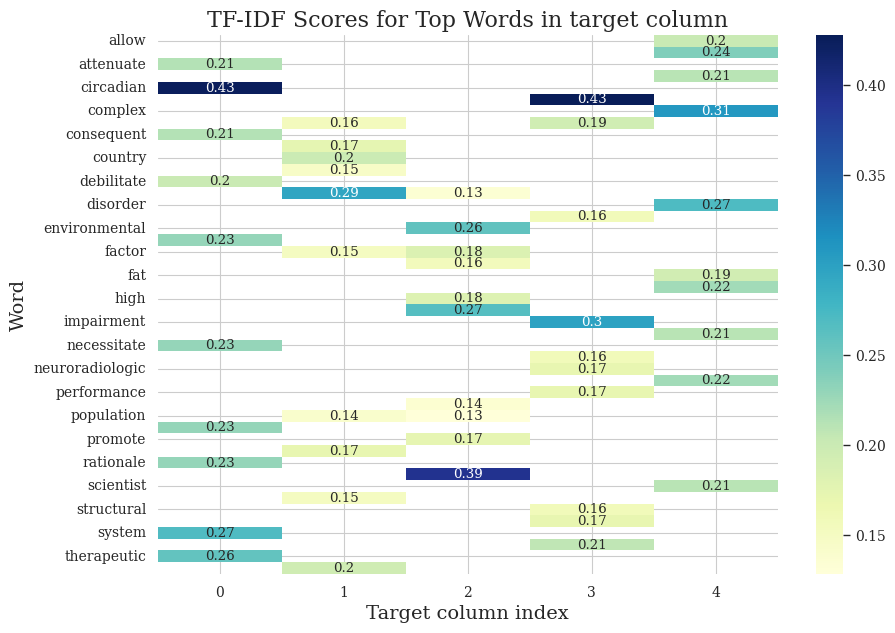

In [36]:

# Define the number of words and conversations to be considered
Nwords = 5
Nconversations = 10

top_tfidf = tfidf_by_word.sort_values(by=['target_col_idx','tfidf'], ascending=[True,False]).groupby(['target_col_idx']).head(10)

# Only consider the first 5 conversations
top_tfidf = top_tfidf.iloc[:Nwords*Nconversations]

# Function to get top N words by TF-IDF score
def get_top_n_words(df, n=10):
    return df.nlargest(n, 'tfidf')

# Get top 10 words for each conversation
top_words_per_conversation = top_tfidf.groupby('target_col_idx', group_keys=False).apply(get_top_n_words)

# Create a pivot table for heatmap
pivot_table = top_words_per_conversation.pivot(index='term', columns='target_col_idx', values='tfidf')

# Create the heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(pivot_table, annot=True, cmap='YlGnBu', cbar=True)
plt.xlabel('Target column index')
plt.ylabel('Word')
plt.title('TF-IDF Scores for Top Words in target column')
plt.show()

# Topic Modelling with Latent Dirichlet Allocation

Next, let’s work to transform the textual data in a format that will serve as an input for training LDA model. We start by tokenizing the text and removing stopwords.

In [38]:
# Import the gensim library for topic modeling and other NLP tasks
import gensim
# Import the 'simple_preprocess' function from gensim for text preprocessing
from gensim.utils import simple_preprocess
# Import 'corpora' from gensim for working with textual data
import gensim.corpora as corpora
# Import 'pprint' from the 'pprint' library to pretty-print output
from pprint import pprint


# Define a function to convert sentences to words
def sent_to_words(sentences):
    # Loop over each sentence in the list of sentences
    for sentence in sentences:
        # Use gensim's simple_preprocess to convert the sentence to a list of words.
        # The 'deacc=True' argument removes punctuations.
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

# Get the target column values from the 'data' DataFrame as a list
data_words = data[target_column].values.tolist()

# Apply the 'sent_to_words' function to preprocess the data
# The result is a list of lists, where each inner list contains words from a document
data_words = list(sent_to_words(data_words))


In [47]:
# words from the first document
print_list(data_words[0])

epidemic necessitate development novel therapeutic preventative strategy attenuate expansion debilitate
disease evidence link circadian system various aspect pathophysiology treatment aim
review outline rationale therapeutic target circadian system treatment prevention consequent
metabolic comorbidities


 Next, we convert the tokenized object into a corpus (set of texts in a structured manner) and dictionary containing value pairs.

In [48]:
# Create a Dictionary from the processed data_words
# The Dictionary object maps each unique word in the data to a unique integer ID
id2word = corpora.Dictionary(data_words)

# Create a Corpus using the original preprocessed data_words
# In this context, a "corpus" is simply a collection of documents (texts)
texts = data_words

# Create a Term Document Frequency corpus using the Dictionary
# 'doc2bow' counts the number of occurrences of each distinct word and converts the word to its integer ID
# The corpus is a list of vectors, one vector per document
corpus = [id2word.doc2bow(text) for text in texts]

# View a portion of the corpus to understand its structure
# The corpus is a list of lists, where each inner list contains tuples (word ID, word frequency) for a document
# The following line prints the first 30 word ID and frequency pairs for the first document in the corpus
print(corpus[:1][0][:30])


[(0, 1), (1, 1), (2, 1), (3, 2), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 2), (24, 1), (25, 2), (26, 2), (27, 1)]


In [49]:
# Set the number of topics to be extracted by the LDA model
num_topics = 4

# Build the LDA model using gensim's LdaMulticore
# 'corpus' contains the bag-of-words representation of each document
# 'id2word' is a dictionary that maps word IDs to actual words
# 'num_topics' specifies the number of topics to be extracted
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)

# Pretty-print the topics extracted by the LDA model
# Each topic is represented as a list of keywords and their associated weights
pprint(lda_model.print_topics())

# Apply the LDA model to the corpus to transform each document into a distribution of topics
# 'doc_lda' will contain the topic distribution for each document in the corpus
doc_lda = lda_model[corpus]

[(0,
  '0.012*"tdm" + 0.010*"patient" + 0.010*"insulin" + 0.009*"disease" + '
  '0.007*"treatment" + 0.007*"risk" + 0.006*"complication" + 0.006*"glucose" + '
  '0.006*"associate" + 0.006*"increase"'),
 (1,
  '0.012*"disease" + 0.012*"patient" + 0.010*"tdm" + 0.007*"review" + '
  '0.007*"risk" + 0.006*"treatment" + 0.006*"factor" + 0.006*"study" + '
  '0.006*"increase" + 0.005*"management"'),
 (2,
  '0.015*"risk" + 0.013*"patient" + 0.013*"disease" + 0.011*"tdm" + '
  '0.010*"factor" + 0.009*"treatment" + 0.008*"insulin" + 0.008*"complication" '
  '+ 0.007*"study" + 0.007*"increase"'),
 (3,
  '0.015*"tdm" + 0.009*"disease" + 0.009*"patient" + 0.008*"insulin" + '
  '0.008*"risk" + 0.007*"increase" + 0.006*"care" + 0.006*"study" + '
  '0.006*"glucose" + 0.006*"control"')]


# Visualization!!!

In [52]:
save = False
load = False
LDAvis_savepath = os.path.join('ldavis_prepared_'+str(num_topics))
LDAvis_loadpath = os.path.join('ldavis_prepared_'+str(num_topics))

# Enable the notebook mode for pyLDAvis
# This allows for interactive topic model visualization inline in a Jupyter Notebook
pyLDAvis.enable_notebook()
# Prepare LDA visualization using the LDA model, corpus, and dictionary
LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)

if save:
    # Save the LDA visualization as an HTML file
    pyLDAvis.save_html(LDAvis_prepared, 'ldavis_prepared_'+ str(num_topics) +'.html')
    # Save the prepared LDA visualization data to a file using pickle
    with open(LDAvis_savepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
if load:
    with open(LDAvis_loadpath, 'rb') as f:
        LDAvis_prepared = pickle.load(f)


# Display the prepared LDA visualization
# Note: This would display the interactive LDA visualization inline if run in a Jupyter Notebook
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.022306 -0.001995       1        1  44.280134
0     -0.005548 -0.019030       2        1  22.073547
3      0.003233  0.015468       3        1  19.297432
1     -0.019990  0.005557       4        1  14.348887, topic_info=                 Term        Freq       Total Category  logprob  loglift
194               tdm  171.000000  171.000000  Default  30.0000  30.0000
21             review   62.000000   62.000000  Default  29.0000  29.0000
8             disease  163.000000  163.000000  Default  28.0000  28.0000
212           patient  167.000000  167.000000  Default  27.0000  27.0000
208             liver   17.000000   17.000000  Default  26.0000  26.0000
199              care   62.000000   62.000000  Default  25.0000  25.0000
371               use   33.000000   33.000000  Default  24.0000  24.0000
468                dm   43.000000   43.000000  Default  23.0000  23.0000
134           insulin  119.000000  119.000000  Default  22.0000  22.0000
180               low   45.000000   45.000000  Default  21.0000  21.0000
94            therapy   50.000000   50.000000  Default  20.0000  20.0000
181        management   61.000000   61.000000  Default  19.0000  19.0000
58             health   52.000000   52.000000  Default  18.0000  18.0000
121           glucose   69.000000   69.000000  Default  17.0000  17.0000
232              drug   33.000000   33.000000  Default  16.0000  16.0000
62           increase   98.000000   98.000000  Default  15.0000  15.0000
268                td   15.000000   15.000000  Default  14.0000  14.0000
57               gene   26.000000   26.000000  Default  13.0000  13.0000
768             model   23.000000   23.000000  Default  12.0000  12.0000
7         development   57.000000   57.000000  Default  11.0000  11.0000
179         important   33.000000   33.000000  Default  10.0000  10.0000
35             common   29.000000   29.000000  Default   9.0000   9.0000
132        individual   34.000000   34.000000  Default   8.0000   8.0000
453             level   39.000000   39.000000  Default   7.0000   7.0000
150            reduce   29.000000   29.000000  Default   6.0000   6.0000
197           article   28.000000   28.000000  Default   5.0000   5.0000
401             study   95.000000   95.000000  Default   4.0000   4.0000
163         associate   71.000000   71.000000  Default   3.0000   3.0000
54            failure   18.000000   18.000000  Default   2.0000   2.0000
718              lead   26.000000   26.000000  Default   1.0000   1.0000
1247              imp    5.609939    6.293405   Topic1  -7.0553   0.6997
2066             mody   12.202290   14.346350   Topic1  -6.2783   0.6528
1204         interval    6.016701    7.154270   Topic1  -6.9853   0.6415
2275          expense    2.501006    3.033749   Topic1  -7.8632   0.6215
1203     hypertensive    5.780638    7.066416   Topic1  -7.0254   0.6138
1207     preeclampsia    4.041873    5.010278   Topic1  -7.3832   0.5999
120       gestational    5.623196    7.026822   Topic1  -7.0530   0.5918
1271       hepatocyte    3.971545    4.983834   Topic1  -7.4007   0.5876
1201      credibility    3.156708    3.982291   Topic1  -7.6303   0.5823
337               sex   10.041004   12.899500   Topic1  -6.4732   0.5641
451     heterogeneous    3.635809    4.888413   Topic1  -7.4890   0.5186
1208        pregnancy    7.978238   10.731375   Topic1  -6.7032   0.5182
1196         bayesian    2.144029    2.904072   Topic1  -8.0172   0.5112
1206             pool    2.138441    2.902522   Topic1  -8.0198   0.5091
2355         mutation    2.835200    3.853896   Topic1  -7.7378   0.5077
796     independently    5.001315    6.827726   Topic1  -7.1702   0.5033
1243           enzyme    3.550741    4.849081   Topic1  -7.5127   0.5030
2065         maturity    3.509694    4.812594   Topic1  -7.5244   0.4989
910              host    3.513416    4.825909   Topic1  

For (1), you can manually select each topic to view its top most frequent and/or “relevant” terms, using different values of the λ parameter. This can help when you’re trying to assign a human interpretable name or “meaning” to each topic.

For (2), exploring the Intertopic Distance Plot can help you learn about how topics relate to each other, including potential higher-level structure between groups of topics.

## Excercises:

#### 1) Through exploration:
##### a) Look at the LDA visualization and determine a relevant number of topics.
##### b) Name the topics based on associated words.

#### 2) Look at the LDA visualization and add words to the stop list that you think are irrelevant and want to remove.
##### a) How did the LDA change?


#### 3) Now look at the LDA visualization through different lamda (λ) scopes.
##### a) How does it differ from λ 0.3 to a λ of 1?
##### b) Explain why 0.3 (0.33) is an optimal lamda (λ) score?